#### 주제 : 주조 공정의 온실가스 배출량 예측 및 죄적화 

#### 변수 설정
-----------------------------------------------------------------------------------------------------------------
온도 관련 변수 
 - molten_temp (용탕 온도) : 금속을 녹이는 온도
 - upper_mold_temp1, upper_mold_temp2, upper_mold_temp3, lower_mold_temp1, lower_mold_temp2, lower_mold_temp3 (상/하형 온도): 주조 시 주형의 온도
 - sleeve_temperature (슬리브 온도) 

압력 및 속도 관련 변수
 - cast_pressure (주조 압력)
 - low_section_speed, high_section_speed (주조 속도)
 
설비 및 공정 시간 관련 변수
 - facility_operation_cycleTime (설비 운영 사이클 타임)
 - production_cycletime (생산 사이클 타임)
 - EMS_operation_time (EMS 운영 시간)

기타 에너지 관련 변수 및 에너지 상태 중단 관련 변수
 - Coolant_temperature (냉각수 온도)
 - heating_furnace (가열로 상태)

 - emergency_stop (비상 정지)
 - working (작동 상태)
-----------------------------------------------------------------------------------------------------------------


[1] 모듈 호출

In [176]:
# 모듈로딩
# - Model 관련 
import torch                                    # 텐서 및 수치 계산 함수 관련 모듈 
import torch.nn as nn                           # 인공신경망 관련 모듈 
import torch.nn.functional as F                 # 손실, 거래 등 함수 관련 모듈 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim                     # weight,  bias 최적화 기반 관련 모듈
import torch.optim.lr_scheduler as lr_scheduler # 최적화 스케줄링 관련 모듈 

from torchmetrics.regression import R2Score, MeanAbsoluteError # 성능지표 관련 모듈
from torchinfo import summary
from sklearn.preprocessing import StandardScaler # 표준화 스케일링
import joblib

# Data 처리 및 시각화 관련
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
import seaborn as sns
import koreanize_matplotlib                     # 시각화 한글 호환
from scipy.stats.mstats import winsorize        # 원저화

[2] 데이터 로딩

In [177]:
data = pd.read_csv(r"C:\Hwan\K-AI & project\경진대회용 주조 공정최적화 데이터셋.csv", encoding='cp949')
data = pd.DataFrame(data)
data

C:\Users\hwans\AppData\Local\Temp\ipykernel_25464\1380534819.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Hwan\K-AI & project\경진대회용 주조 공정최적화 데이터셋.csv", encoding='cp949')


,Unnamed: 0,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B
2,2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B
3,3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,...,NaN,483.0,0.0,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B
4,4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,...,NaN,486.0,0.0,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,92010,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:51:29,71,가동,ON,731.0,...,1449.0,279.0,726.0,30.0,0,2019-03-31 23:51:29,0.0,NaN,8917,A
92011,92011,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:53:28,72,가동,ON,731.0,...,1449.0,279.0,732.0,30.0,0,2019-03-31 23:53:28,0.0,NaN,8917,A
92012,92012,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:55:44,73,가동,ON,732.0,...,1449.0,272.0,731.0,30.0,0,2019-03-31 23:55:44,0.0,NaN,8917,A
92013,92013,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:57:46,74,가동,ON,732.0,...,1449.0,288.0,723.0,30.0,0,2019-03-31 23:57:46,0.0,NaN,8917,A


In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92015 entries, 0 to 92014
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    92015 non-null  int64  
 1   line                          92015 non-null  object 
 2   name                          92015 non-null  object 
 3   mold_name                     92015 non-null  object 
 4   time                          92015 non-null  object 
 5   date                          92015 non-null  object 
 6   count                         92015 non-null  int64  
 7   working                       92014 non-null  object 
 8   emergency_stop                92014 non-null  object 
 9   molten_temp                   89754 non-null  float64
 10  facility_operation_cycleTime  92015 non-null  int64  
 11  production_cycletime          92015 non-null  int64  
 12  low_section_speed             92014 non-null  float64
 13  h

[2-1] 데이터 전처리
- [1] 결측치 처리
- 결측치의 수가 데이터의 5% 이상인 칼럼은 삭제 
- 그 이하는 모델의 정확도를 위해 평균값으로 대체
- [2] 인코딩 
- working 칼럼에서 가동/정지 => 원핫인코딩 
- emergency_stop 칼럼 on/결측치(1) => 결측치 포함 행 삭제 
- [3] data 스케일링 
- 표준화를 통한 스케일링 
- [4] 이상치 
- 각 칼럼별 이상치가 많이 존재 -> 제거하는 것이 오히려 의미 있는 정보를 잃는 결과 ==> 이상치를 경계값으로 조정 (극단적인 값을 줄이는)
- Winsorization (원저화) 사용하여 상하위 5% 값들을 경계값을 제한
<hr>

In [179]:
# 결측치가 많은 칼럼 삭제 
data = data.drop(columns=['tryshot_signal', 'heating_furnace', 'Unnamed: 0', 'registration_time', "molten_volume"], errors='ignore')

# 결측치를 평균값으로 
data['molten_temp'].fillna(data['molten_temp'].mean(), inplace=True)
data['low_section_speed'].fillna(data['low_section_speed'].mean(), inplace=True)
data['high_section_speed'].fillna(data['high_section_speed'].mean(), inplace=True)
data['biscuit_thickness'].fillna(data['biscuit_thickness'].mean(), inplace=True)
data['upper_mold_temp1'].fillna(data['upper_mold_temp1'].mean(), inplace=True)
data['upper_mold_temp2'].fillna(data['upper_mold_temp2'].mean(), inplace=True)
data['upper_mold_temp3'].fillna(data['upper_mold_temp3'].mean(), inplace=True)
data['lower_mold_temp1'].fillna(data['lower_mold_temp1'].mean(), inplace=True)
data['lower_mold_temp2'].fillna(data['lower_mold_temp2'].mean(), inplace=True)
data['lower_mold_temp3'].fillna(data['lower_mold_temp3'].mean(), inplace=True)
data['sleeve_temperature'].fillna(data['sleeve_temperature'].mean(), inplace=True)
data['physical_strength'].fillna(data['physical_strength'].mean(), inplace=True)
data['Coolant_temperature'].fillna(data['Coolant_temperature'].mean(), inplace=True)
data['passorfail'].fillna(data['passorfail'].mean(), inplace=True)

[2-1-2] 인코딩

In [180]:
# emergency 행에서 결측치를 포함하는 행 삭제 
data = data.dropna(subset=['emergency_stop'])

# working 칼럼 원핫 인코딩
# 가동 True = 1 // 가동 Flase = 0
data = pd.get_dummies(data, columns=['working'])

In [181]:
# 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92014 entries, 0 to 92014
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line                          92014 non-null  object 
 1   name                          92014 non-null  object 
 2   mold_name                     92014 non-null  object 
 3   time                          92014 non-null  object 
 4   date                          92014 non-null  object 
 5   count                         92014 non-null  int64  
 6   emergency_stop                92014 non-null  object 
 7   molten_temp                   92014 non-null  float64
 8   facility_operation_cycleTime  92014 non-null  int64  
 9   production_cycletime          92014 non-null  int64  
 10  low_section_speed             92014 non-null  float64
 11  high_section_speed            92014 non-null  float64
 12  cast_pressure                 92014 non-null  float64
 13  biscui

In [182]:
print(data["working_가동"].value_counts())
print(data["working_정지"].value_counts())

working_가동
True     91963
False       51
Name: count, dtype: int64
working_정지
False    91963
True        51
Name: count, dtype: int64


In [183]:
data = data.drop(columns=["working_정지"])

In [184]:
data["working_가동"] = data["working_가동"].astype(int)

In [185]:
# 최종 결측치 확인
data.isna().sum()

line                            0
name                            0
mold_name                       0
time                            0
date                            0
count                           0
emergency_stop                  0
molten_temp                     0
facility_operation_cycleTime    0
production_cycletime            0
low_section_speed               0
high_section_speed              0
cast_pressure                   0
biscuit_thickness               0
upper_mold_temp1                0
upper_mold_temp2                0
upper_mold_temp3                0
lower_mold_temp1                0
lower_mold_temp2                0
lower_mold_temp3                0
sleeve_temperature              0
physical_strength               0
Coolant_temperature             0
EMS_operation_time              0
passorfail                      0
mold_code                       0
working_가동                      0
dtype: int64

[2-1-3] 스케일링

In [186]:
scaler = StandardScaler()
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_features] = scaler.fit_transform(data[numeric_features])

[2-2] 상관관계 확인

In [187]:
data_corr = data.corr(numeric_only=True)

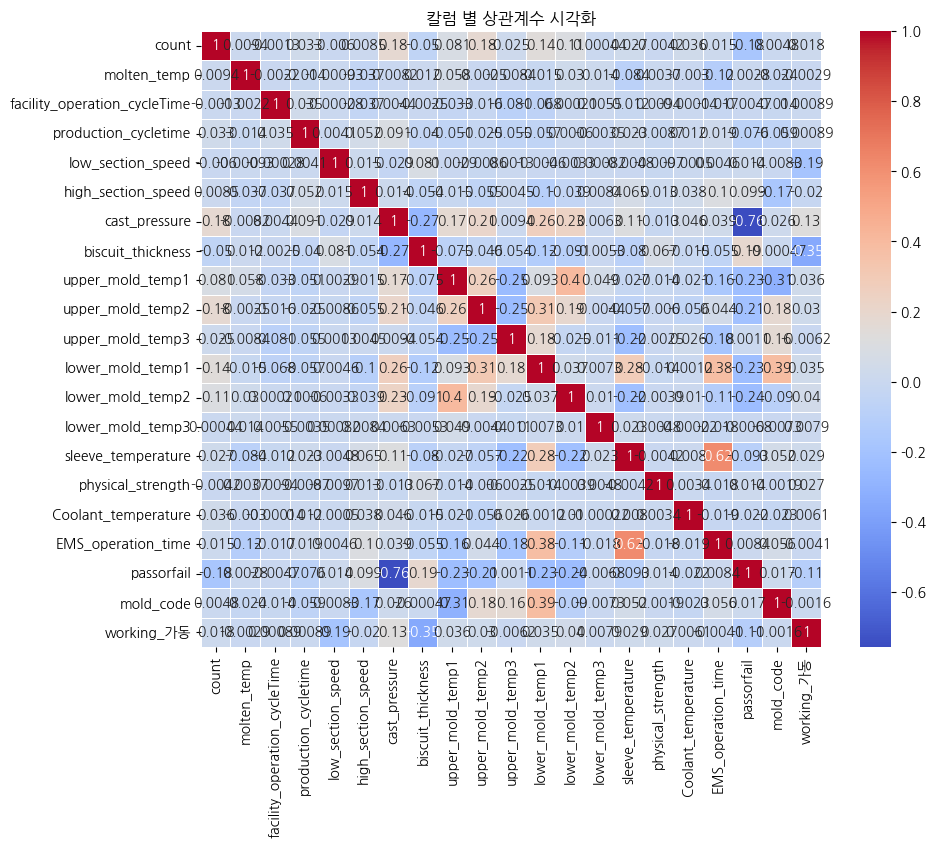

In [188]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('칼럼 별 상관계수 시각화')
plt.show()

In [189]:
data.columns

Index(['line', 'name', 'mold_name', 'time', 'date', 'count', 'emergency_stop',
       'molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature', 'EMS_operation_time', 'passorfail', 'mold_code',
       'working_가동'],
      dtype='object')

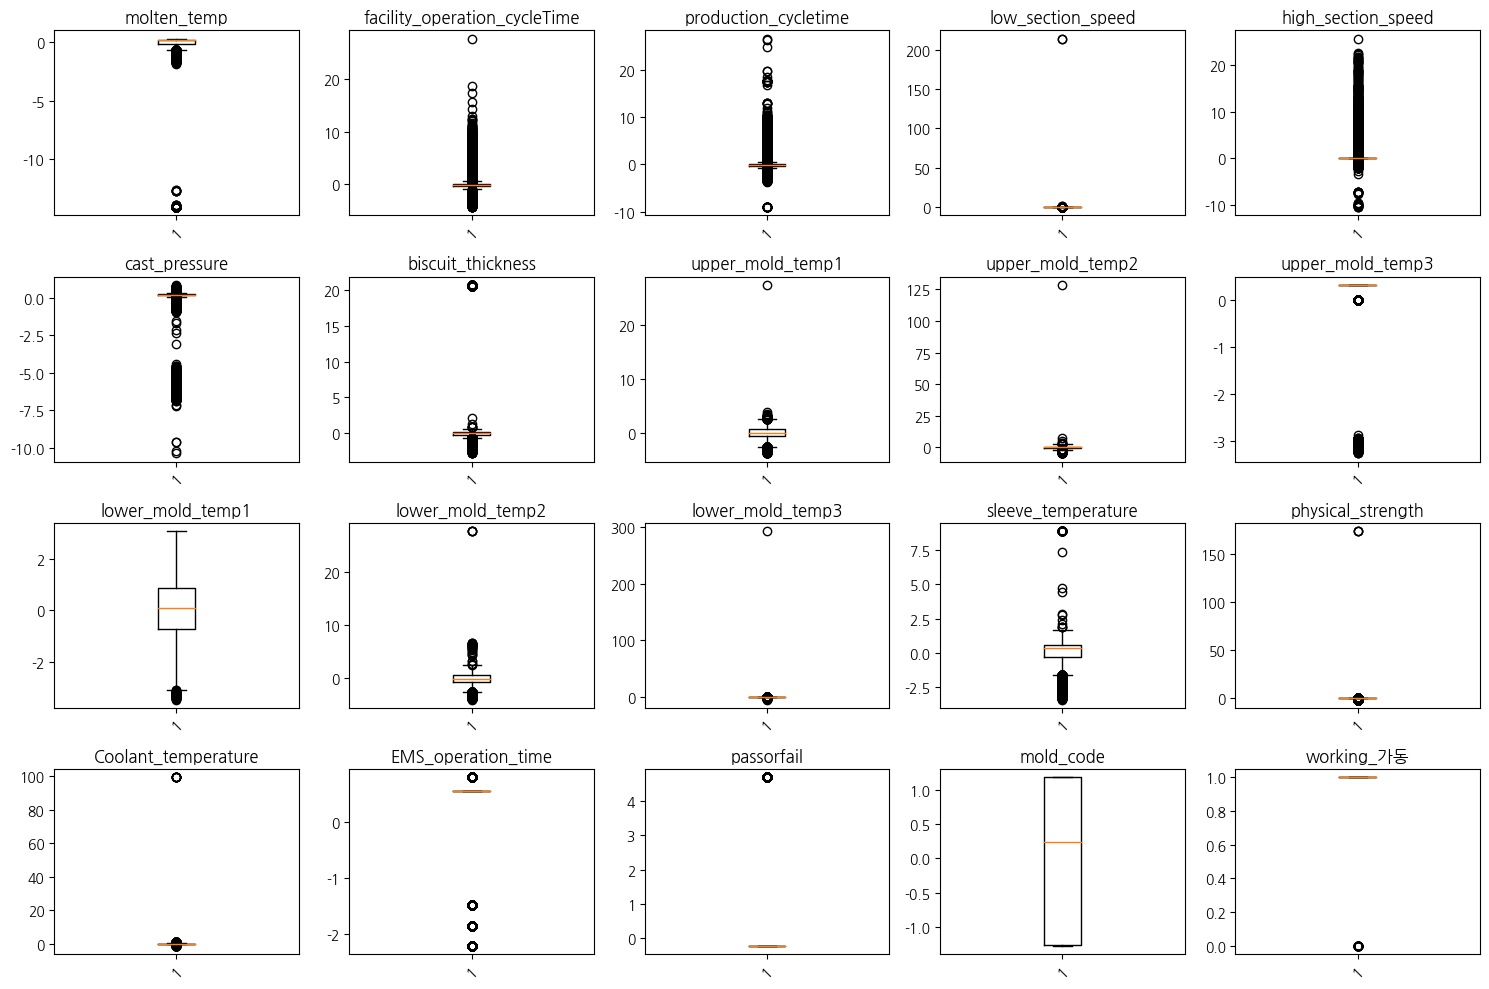

In [190]:
columnsList = ['molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature', 'EMS_operation_time', 'passorfail', 'mold_code',
       'working_가동']

plt.figure(figsize=(15, 10))
for i, col in enumerate(columnsList, 1):
    plt.subplot(4, 5, i)  
    plt.boxplot(data[col].dropna())
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

[2-1-4] 이상치를 경계값으로 조절 Winsorization 

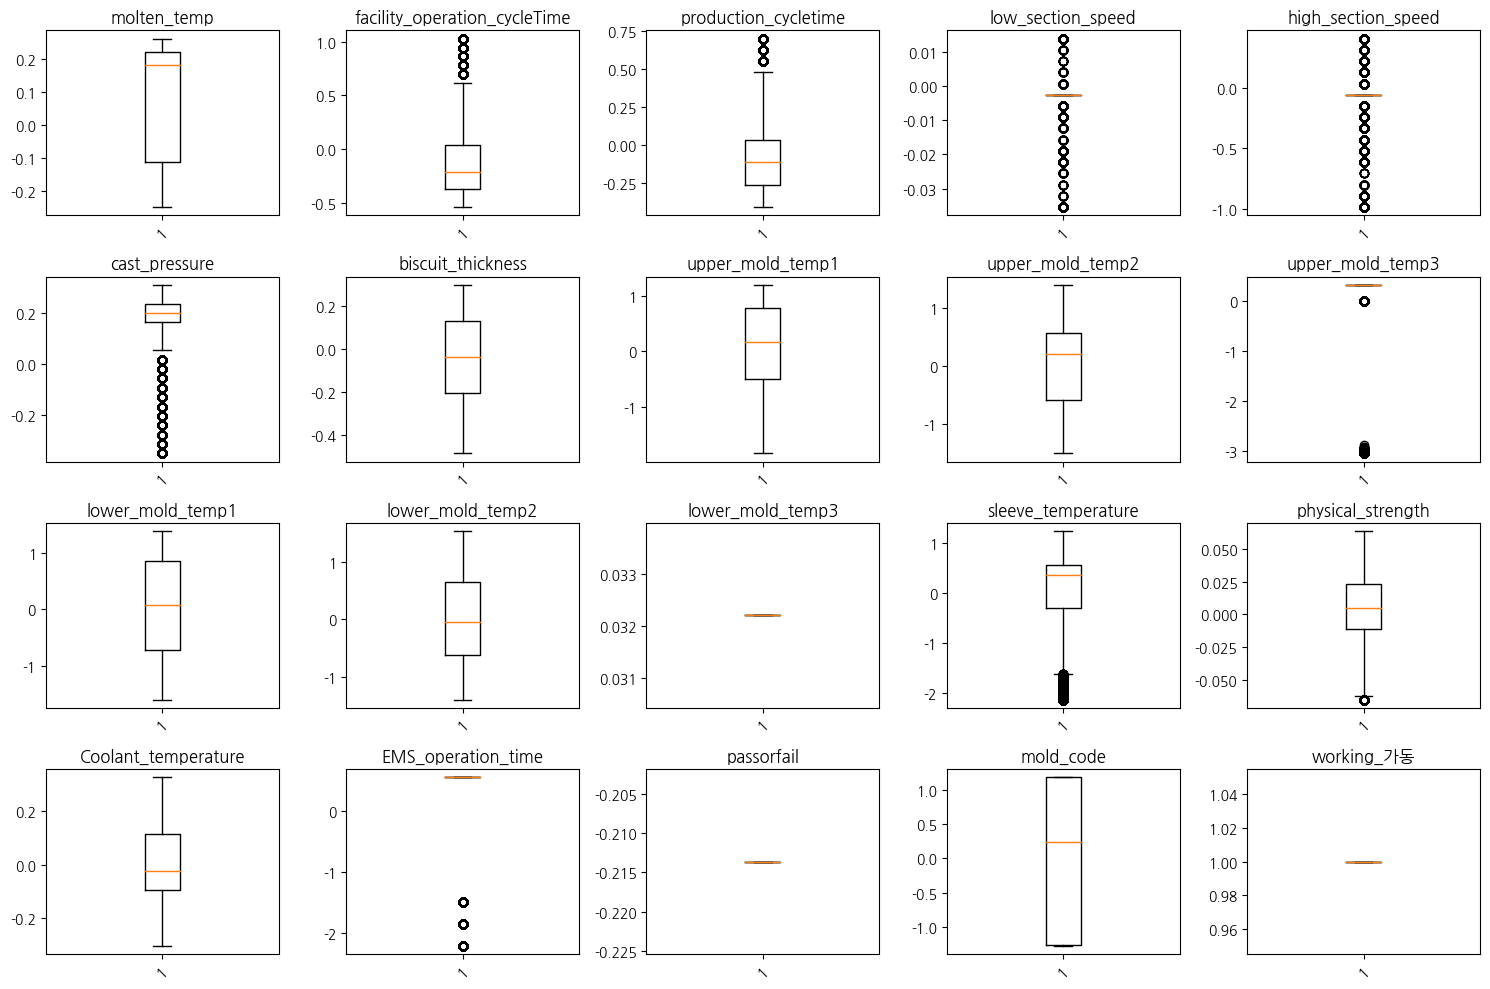

In [191]:
for col in columnsList:
    data[col] = winsorize(data[col], limits=[0.05, 0.05])

plt.figure(figsize=(15, 10))
for i, col in enumerate(columnsList, 1):
    plt.subplot(4, 5, i)  
    plt.boxplot(data[col].dropna())
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

[3] 모델 학습 전 준비
- MLP, RNN(LSTM), CNN, DNN
<hr>

- MLP (MLP, Multi-Layer Perceptron, 다층 퍼셉트론)

In [192]:
# 활동패키지 버전 체크
print(f"torch v.{torch.__version__}")
print(f"Pandas v.{pd.__version__}")

torch v.2.4.1
Pandas v.2.0.3


- RNN

In [193]:
featureList = ['molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature', 'passorfail', 'mold_code',
       'working_가동']

X = data[featureList]

y = data['EMS_operation_time'] 

X_scaled = scaler.fit_transform(X)

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [197]:
# 인덱스 리셋
X_train = pd.DataFrame(X_train).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
X_val = pd.DataFrame(X_val).reset_index(drop=True)
y_val = pd.Series(y_val).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

In [198]:
# 커스텀 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features.to_numpy() 
        self.targets = targets.to_numpy().flatten() 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = torch.tensor(self.features[index], dtype=torch.float32)
        target = torch.tensor(self.targets[index], dtype=torch.float32)
        return feature, target

In [199]:
# 데이터셋 생성
trainDS = CustomDataset(X_train, y_train)
vaLDS = CustomDataset(X_val, y_val)
testDS = CustomDataset(X_test, y_test)

# DataLoader 생성
trainDL = DataLoader(trainDS, batch_size=64, shuffle=True)
valDL = DataLoader(vaLDS, batch_size=64, shuffle=False)

In [200]:
# RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        return x

In [201]:
## 모델 파일관련
import os 

# 저장 경로
SAVE_PATH = '../models/RNN/'

#  저장 파일명
SAVE_FILE=SAVE_PATH+'RNNmodel_train_wb.pth'

# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL = SAVE_PATH+'RNNmodel_all.pth'

# 경로상 폴더 존재여부 체크 
if not os.path.exists(SAVE_PATH) :
    os.makedirs(SAVE_PATH)

In [216]:
# 모델 하이퍼파라미터 정의
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1

# 모델 초기화
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
LOSS_HISTORY_TRAIN, LOSS_HISTORY_VAL = [], []
SCORE_HISTORY_TRAIN, SCORE_HISTORY_VAL = [], []
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0
    train_score = 0.0
    for features, targets in trainDL:
        # 데이터를 3D 형태로 변환 (batch_size, 1, input_size)
        features = features.view(-1, 1, input_size)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets.unsqueeze(1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)
        train_score += (1 - loss.item()) * features.size(0)

    # 에포크 당 평균 손실 및 스코어 계산
    train_loss /= len(trainDL.dataset)
    train_score /= len(trainDL.dataset)
    LOSS_HISTORY_TRAIN.append(train_loss)
    SCORE_HISTORY_TRAIN.append(train_score)
    LOSS_HISTORY_VAL.append(val_loss)
    SCORE_HISTORY_VAL.append(val_score)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    val_score = 0.0
    with torch.no_grad():
        for features, targets in valDL:
            features = features.view(-1, 1, input_size)
            outputs = model(features)
            loss = criterion(outputs, targets.unsqueeze(1))
            val_loss += loss.item() * features.size(0)
            val_score += (1 - loss.item()) * features.size(0)

    val_loss /= len(valDL.dataset)
    val_score /= len(valDL.dataset)
    LOSS_HISTORY_VAL.append(val_loss)
    SCORE_HISTORY_VAL.append(val_score)

    # 에포크 결과 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Score: {train_score:.4f}, Validation Loss: {val_loss:.4f}, Validation Score: {val_score:.4f}')

    # 모델을 훈련 모드로 다시 설정
    model.train()

# 모델 평가
model.eval()
with torch.no_grad():
    test_features = torch.tensor(X_test.to_numpy(), dtype=torch.float32).view(-1, 1, input_size)
    test_targets = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)
    test_outputs = model(test_features)
    test_loss = criterion(test_outputs, test_targets)
    test_score = 1 - test_loss.item()
    print(f"Test Loss: {test_loss.item():.4f}, Test Score: {test_score:.4f}")

# 모델 파라미터 저장 
torch.save(model.state_dict(), SAVE_FILE)

# 구조 및 파라미터 저장
torch.save(model, SAVE_MODEL)

Epoch [1/50], Train Loss: 0.2491, Train Score: 0.7509, Validation Loss: 0.1061, Validation Score: 0.8939
Epoch [2/50], Train Loss: 0.1022, Train Score: 0.8978, Validation Loss: 0.0705, Validation Score: 0.9295
Epoch [3/50], Train Loss: 0.0786, Train Score: 0.9214, Validation Loss: 0.0582, Validation Score: 0.9418
Epoch [4/50], Train Loss: 0.0675, Train Score: 0.9325, Validation Loss: 0.0460, Validation Score: 0.9540
Epoch [5/50], Train Loss: 0.0584, Train Score: 0.9416, Validation Loss: 0.0379, Validation Score: 0.9621
Epoch [6/50], Train Loss: 0.0508, Train Score: 0.9492, Validation Loss: 0.0328, Validation Score: 0.9672
Epoch [7/50], Train Loss: 0.0457, Train Score: 0.9543, Validation Loss: 0.0272, Validation Score: 0.9728
Epoch [8/50], Train Loss: 0.0416, Train Score: 0.9584, Validation Loss: 0.0234, Validation Score: 0.9766
Epoch [9/50], Train Loss: 0.0382, Train Score: 0.9618, Validation Loss: 0.0222, Validation Score: 0.9778
Epoch [10/50], Train Loss: 0.0367, Train Score: 0.9633,

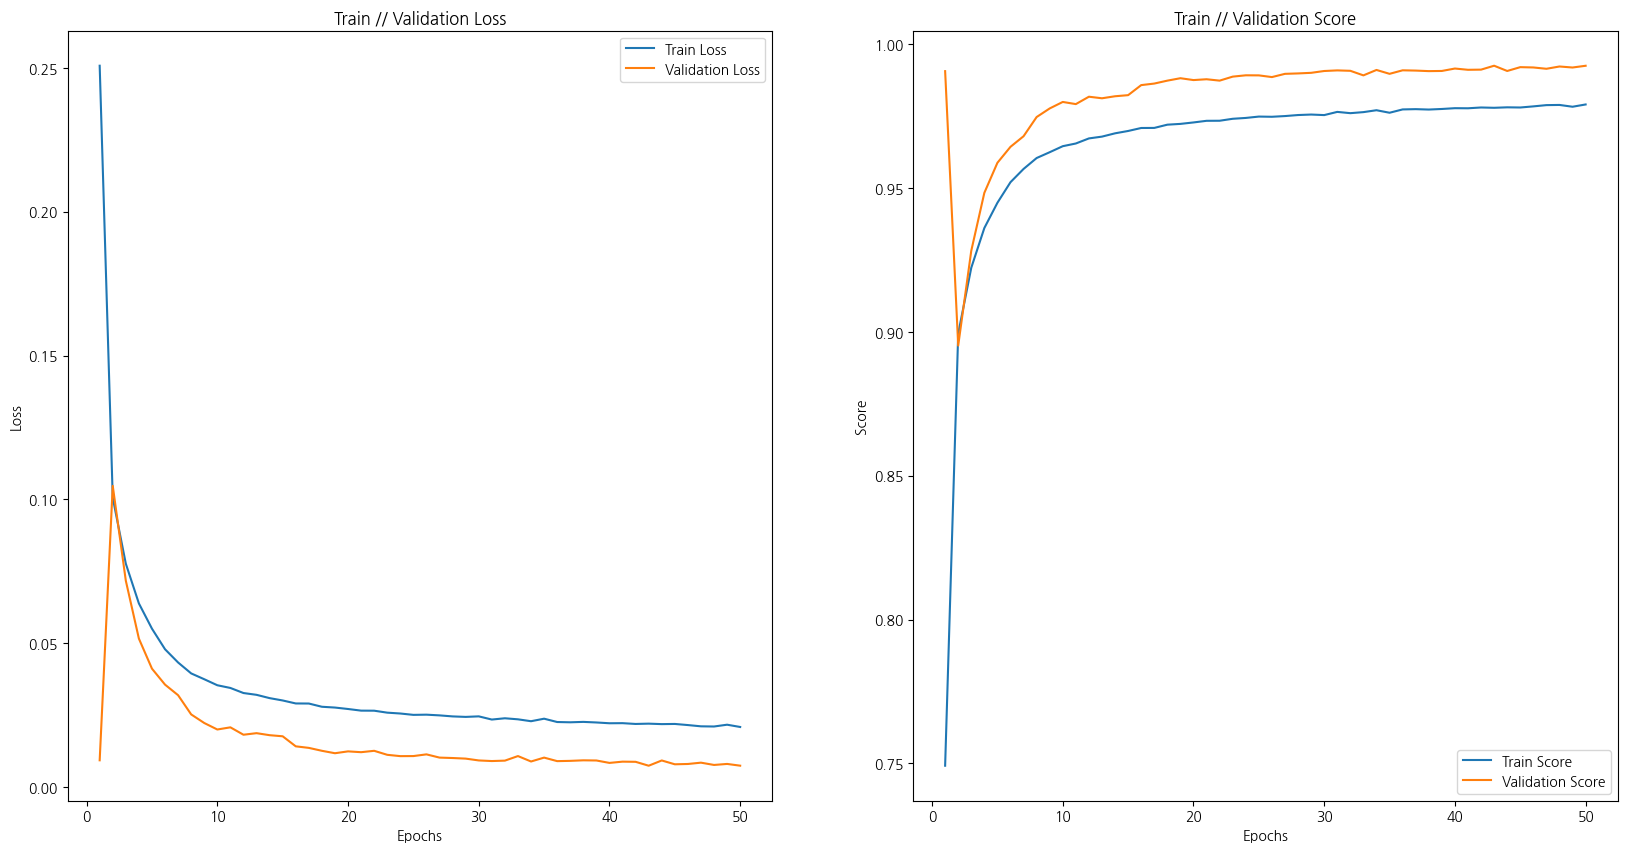

In [214]:
plt.figure(figsize=(20,10))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), LOSS_HISTORY_TRAIN, label='Train Loss')
plt.plot(range(1, num_epochs + 1), LOSS_HISTORY_VAL, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train // Validation Loss')
plt.legend()

# Score 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), SCORE_HISTORY_TRAIN, label='Train Score')
plt.plot(range(1, num_epochs + 1), SCORE_HISTORY_VAL, label='Validation Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train // Validation Score')
plt.legend()

In [215]:
# 스케일러 로드 및 데이터 스케일링
scaler_path = "../models/RNN/RNNmodel_train_wb.pth"
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(X)

# 모델 로드
model_path = '../models/RNN/RNNmodel_all.pth'
model = torch.load(model_path)

model.eval() 

# 데이터 텐서 변환
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1, X_scaled.shape[1])

# 예측 수행
with torch.no_grad():
    predicted_emissions = model(X_tensor).squeeze().numpy()  

# DF 새로운 칼럼 추가
data['온실가스 배출량'] = predicted_emissions

# 결과 확인
print(data.head())

# 예측 결과를 포함한 CSV 파일 저장
data.to_csv("./주조공정_온실가스_예측결과.csv", index=False)

UnpicklingError: persistent IDs in protocol 0 must be ASCII strings